In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import random


In [103]:
df_prueba = pd.DataFrame({
"es_pepito":['s','n','n','s','n','s','n','s','n','s','s','n','s','s','n','s','s','n','n','n','n','s','s','s'],
"es_pepito2":['s','s','s','s','n','s','n','s',None,'s','s','n','s','s',None,'s','s','n','n','n',None,'s','s','s'],
"sexo":['h','m','h','h','m','h','h','m','h','h','m','h','h','m','h','h','m','h','h','m','h','h','m','h'],
"sexo_2":['h','m','h','h','m','h','h','m','h','h','m','h','h','m','h','h','m','h','h','m','h','h','m','h'],
"Datos_B":[np.random.randint(0,5) for _ in range(24)],
"Datos_C":[np.random.randint(0,1) for _ in range(24)],
"Datos_D": [np.random.randint(0,1000) for _ in range(24)],
"Datos_E": [np.random.randint(0,1000) for _ in range(24)],
"Datos_F": [np.random.randint(0,1000) for _ in range(24)],
"Datos_G": [np.random.randint(0,1000) for _ in range(24)],
"Datos_cate_A": ['Grupo '+str(np.random.randint(0,6)) for _ in range(24)],
"Datos_cate_B": ['Grupo '+str(np.random.randint(0,4)) for _ in range(24)],
"Datos_cate_C": ['Grupo '+str(np.random.randint(0,5)) for _ in range(24)],

})

for i in range(1,6):
    df_prueba['Datos_E'][random.randint(0,23)]=None


for i in range(1,10):
    df_prueba['Datos_F'][random.randint(0,23)]=None

for i in range(0,11):
    df_prueba['Datos_G'][i]=None


C:\Users\franc\AppData\Local\Temp\ipykernel_3812\1930774919.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prueba['Datos_E'][random.randint(0,23)]=None
C:\Users\franc\AppData\Local\Temp\ipykernel_3812\1930774919.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prueba['Datos_F'][random.randint(0,23)]=None
C:\Users\franc\AppData\Local\Temp\ipykernel_3812\1930774919.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p

In [104]:

class DF_exploracion(pd.DataFrame):

    def __init__(self, *args, **kw):
        super(DF_exploracion, self).__init__(*args, **kw)
        self.cuanti=pd.DataFrame
        self.cuali=pd.DataFrame
        self.dico=pd.DataFrame
        self.cate=pd.DataFrame
        self.eliminado=pd.DataFrame
        self.dummy=pd.DataFrame
        self.df=pd.DataFrame
        self.df_inputado=pd.DataFrame
        self.df_limpio=pd.DataFrame
        self.normal_cuatis=[]
        self.normal_grupos_dico=[]
        self.normal_grupos_cate=[]
        self.porcentaje_nulos_permitido=0.6

    def variables(self):

        dico=[]
        cuantis=[]
        categori=[]
        eliminar=[]
        

        for i in self.columns: 
            nulos= (self[i].isnull().sum())/len(self[i])
            
            if ((len(self[i].dropna().unique())==2) and (nulos<=self.porcentaje_nulos_permitido)):
                tipo_de_var=f"{len(self[i].dropna().unique())} tipos, posiblemente: DICOTOMICA"
                dico.append(i)

            elif ((len(self[i].dropna().unique())>10) and  (nulos<=self.porcentaje_nulos_permitido)):
                tipo_de_var=f"{len(self[i].dropna().unique())} tipos, posiblemente: CUANTITATIVA"
                cuantis.append(i)

            elif ( (len(self[i].dropna().unique())<2) or (nulos>self.porcentaje_nulos_permitido)):
                tipo_de_var=f"SOLO {len(self[i].dropna().unique())} TIPOS, NO VALE LA COLUMNA"
                eliminar.append(i)
            else:
                tipo_de_var=f"{len(self[i].dropna().unique())} tipos, posiblemente: CATEGORICA/CUANTI"
                categori.append(i)

            print (f"|  {i} \n|   - Tipo de dato: {self[i].dtype} \n|   - Valores repetidos: {tipo_de_var} \n|   - Nulos: {nulos} \n| ")

        print (f"|----------------------------------------------------------------------------------------------------\n|  TODAS: {self.columns} \n|  DICOTOMICAS: {dico} \n|  CATEGORICAS: {categori} \n|  CUANTITATIVAS: {cuantis} \n|  ELIMINAR: {eliminar}")
        print("|----------------------------------------------------------------------------------------------------")

        self.DF_cuantis(cuantis)
        self.DF_cualis(categori+dico)
        self.DF_dicotomica(dico)
        self.DF_categorica(categori)
        self.DF_elimiminado(eliminar)
        self.df=self
        
    def todas_col(self):
        return self.df
    
    def DF_cuantis(self,lista):
        self.cuanti=self[lista]

    def DF_elimiminado(self,lista):
        self.eliminado=self[lista]
        
    def DF_cualis(self,lista):
        self.cuali=self[lista]
        
    def DF_dicotomica(self, lista):
        self.dico=self[lista]
        
    def DF_categorica(self, lista):
        self.cate=self[lista]   



    def limpiar_aux(self):
        
        try:
            df_nuevo=pd.DataFrame
            aux1=list(self.dico.columns)
            aux=[]
            df_nuevo=pd.get_dummies(self.df, columns=aux1)
            
            for columna in df_nuevo.columns:
                for variables in list(self.dico.columns):
                    if variables in columna:
                        aux.append(columna)
                    
            self.dummy=df_nuevo[aux]
            self[aux]=df_nuevo[aux]

            # self.df=self.drop(columns=var, axis='columns')
            # self.df= self[self.columns.difference(self.dico.columns)]
            
            print("********************** self.dummy ************\n")
            print(self.dummy)
            print("\n********************** self.df o todas_las_col() ************\n")
            print(self.df)

        except:
            print("---------------------- ERROR -----------------")



    def limpiar_dummys(self):

        b=False
        lista=list(self.dico.columns)
        for ind, i in enumerate(lista):
                if (ind+1<len(lista)):
                    if( (i in lista [ind+1]) ):
                        b=True
                        break
        if b:
            nombres_nuevos=[]
            if len(lista)>2:
                for ind, i in enumerate(lista):
                    if (ind+1<len(lista)):
                        if( (i in lista [ind+1]) ):
                            nombres_nuevos.append(i.upper())
                        else:
                            nombres_nuevos.append(i)
                    else:
                        nombres_nuevos.append(i)
                        
            aux_df=self.df

            for i,j in zip(lista,nombres_nuevos):
                aux_df.rename(columns={i:j},inplace=True)
                
            self.df=aux_df
            self.dico.columns=nombres_nuevos
            
            self.limpiar_aux()
        else: 
            self.limpiar_aux()



    def estadistica_descriptiva_cuantis(self):

        print("----------------------------------------------------------------------------------------------------\nDESCRIPCIÓN")
        print (self.cuanti.describe())
        print("\n")
        print("----------------------------------------------------------------------------------------------------\nCUARTILES")
        print (self.cuanti.quantile([0.05,0.25,0.5,0.75,0.95]))
        print("\n")
        print("----------------------------------------------------------------------------------------------------\n")
        print("\n")
        print("----------------------------------------------------------------------------------------------------\n")


        aux1=self.dico.columns
        aux2=self.cate.columns
        aux=self.cuanti.columns

        # df_auxiliar = self.groupby('sexo').apply(lambda x: pd.Series(shapiro(x), index=['W','P'])).reset_index()
        # print(df_auxiliar)
                
        for a in list(aux1.values):
            
            for b in list(aux.values):
                
                print("++++++++++++++++++++++++++++  "+a+" y "+b+"  ++++++++++++++++++++++++++\n")
                agrupado=self.groupby(a)[b]
                titulo=f"Agrupado por {a} y por {b}"
                print(titulo)
                print(agrupado.describe().reset_index())
                # df.groupby(['cat1', 'cat2'])['purchases','sales'].apply(stats.shapiro)
                print("////////////////////////// TEST DE SHAPIRO ////////////////////////////")
                aux_shapiro=(agrupado.apply(stats.shapiro))
                print(aux_shapiro)
        
                
                print("\n")
                print("----------------------------------------------------------------------------------------------------\n")


    def estadistica_descriptiva_cualis(self):

        print("\n--------------------- Variables dico ---------------------")
        print("\n")
        for i in self.dico.columns:
            print(f"...........Frecuencia variable {i} ....................")
            print(self[i].value_counts()/(self[i].count()))
            print("\n")

        print("\n-------------------- Variables categoricas --------------------")
        print("\n")
        for i in self.cate.columns:
            print(f"...........Frecuencia variable {i} ....................")
            print(self[i].value_counts()/(self[i].count()))
            print("\n")
        print("\n\n")

        # crosstab variables cualis con cate
        aux=list(self.cate.columns)

        a=0
        for i in aux:
            a=a+1
            if a<len(aux)/2:
                b=0
                for j in aux[:-1]:
                    b=b+1
                    if b > a:
                        print(f"*************** TABAL DE VARIABLES CATEGORICAS {i} y {j} *********************\n ")
                        tab = pd.crosstab (index=self[i], columns=self[j])
                        x=(tab/tab.sum())
                        print(tab)
                        print("\n")
                        print(f"/////////////////// EN PROPORCION //////////////////\n")
                        print(x)
                        print("\n\n")


    def anova(self):

        aux_cate=list(self.cate.columns)
        aux_cuati=list(self.cuanti.columns)

        for i in aux_cate:
            for j in aux_cuati:
                try:
                    print(f"\n----------- ANOVA Categoria {i} y variable continua {j} ----------\n")
                    model = ols(f"{j} ~ {i}", data=self).fit()
                    a=sm.stats.anova_lm(model, typ=2)
                    print(a)
                except:
                    print(f"\n - - - - - Fallo en variable {i} y {j} - - - - - - \n")
                    continue




    def Chi(self):

        aux_dico=list(self.dico.columns)

        if len(aux_dico)>1:
            for ind, i in enumerate(aux_dico):
                for j in range(ind+1,len(aux_dico)):
                    chi, p, dof, expected = stats.chi2_contingency(pd.crosstab(self[i],self[aux_dico[j]]), correction=False)
                    print(f"\n-------------- Chi2 entre {i} y {aux_dico[j]} ----------------")
                    print(f"p: {p} \n") 
        else:
            print("******************** No suficientes argumentos ********************")





    def plot_normailidad(self):

        aux=self.cuanti.columns
        for i in aux:
            stats.probplot(self[i], dist="norm", plot=plt)
            plt.title("Probability Plot - " )
            plt.show()
    


    def plot_bigotes(self):

        aux1=self.dico.columns
        aux2=self.cate.columns
        aux=self.cuanti.columns
        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")

        print("-------------- Graficas de bigotes cualitativas-------------------")
        # fig = plt.figure(figsize=(12, 8))
        
        (self.cuanti).plot(kind='box', title='Variables cuantitativas',figsize=(12, 8))
        plt.show()
        

        print("-------------- Graficas de bigotes por dicotomicas-------------------")   
        
        for a in aux1:

            # fig = plt.figure(figsize=(12, 8))
            self.boxplot(column=list(aux.values), by=a,figsize=(12, 8))
            plt.tight_layout() 
            plt.show()
        
        print("\n")
        print("----------------------------------------------------------------------------------------------------\n")
        
        print("-------------- Graficas de bigotes por categoricas-------------------") 

        for a in aux2:
            # fig = plt.figure(figsize=(12, 8))
            ax= self.boxplot(column=list(aux.values), by=a, figsize=(12, 8))
            # ax = sns.swarmplot(column=list(aux.values), by=a,data=self, color='#7d0013')
            plt.tight_layout() 
            plt.show()
        print("\n")
        print("----------------------------------------------------------------------------------------------------\n")

        
        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")



    def plot_corr(self):

        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")
        print("----------------------------------------------------------------------------------------------------\n")
        
        print("-------------- MATRIZ DE CORRELACIONES ENTRE CUANTITATIVAS -------------------\n") 

        fig = plt.figure(figsize=(12, 8))
        matrix = self.cuanti.corr().round(2)
        mask = np.triu(np.ones_like(matrix, dtype=bool))
        sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)  
        plt.show()

        print("----------------------------------------------------------------------------------------------------\n")

        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")


    def plot_barras(self):
        aux=self.cuanti.columns

        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")
        print("----------------------------------------------------------------------------------------------------\n")

        print("-------------- GRAFICA DE BARRAS DE TODAS LAS CUANTITATIVAS -------------------\n") 
        # fig = plt.figure(figsize=(15, 20))
        self.cuanti.plot.bar(figsize=(18, 8))
        plt.show()

        print("-------------- GRAFICA DE BARRAS CON DISTRIBUCIÓN DE DENSIDAD DE CADA CUANTITATIVA  -------------------\n") 
        for i in list(aux.values):
            fig = plt.figure(figsize=(12, 8))
            print(f"\n.............. GRAFICA DE BARRAS  DE {i} ............\n") 
            ax=self[i].plot.hist(density=True)
            self[i].plot.density(ax=ax)
            plt.show()

        print("----------------------------------------------------------------------------------------------------\n")    
        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")


    def todos_plots(self):

        self.plot_bigotes()
        self.plot_corr()
        self.plot_barras()
        self.violines()
        
        

    def violines(self):

        aux1=self.dico.columns
        aux2=self.cate.columns
        aux=self.cuanti.columns

        print("--------------  GRAFICA DE VIOLINES  -------------------\n") 
        sns.set(style="whitegrid")
        for i in aux2:
            for j in aux:
                ax= sns.violinplot(x=self[i], y=self[j], palette="Set2", split=True, inner="quartile",scale="count")
                plt.show()

        print("\n\n/////////-------------- GRAFICA DE VIOLINES POR DICOTOMICAS -------------------/////////////\n") 
        
        for i in aux2:
            for j in aux:
                for k in aux1:
                    ax= sns.violinplot(x=self[i], y=self[j], hue=self[k],palette="Set2", split=True, inner="quartile",scale="count")
                    plt.show()


    def cross_var_cualis_con_ciantis(self):

        aux=list(self.cate.columns)
        aux_cuati=list(self.cuanti.columns)

        for k in aux_cuati:
            a=0
            for i in aux:
                a=a+1
                if a<len(aux)/2:
                    b=0
                    for j in aux[:-1]:
                        b=b+1
                        if b > a:
                            print(f"\n\n*************** TABAL DE VARIABLES CATEGORICAS {i} y {j} con valores de {k} MEDIA *********************\n ")
                            tab = pd.crosstab (index=self[i], columns=self[j],values=self[k],aggfunc=np.mean)
                            print(tab)
                            print("\n\n")

    def nulos(self):
        aux_df=list(self.cuanti.columns)
        aux_DF=self.cuanti
        self.df_inputado=self.df
        for i in aux_df:
            nulos=aux_DF[i].isna().sum()
            total=len(aux_DF[i])
            porcentaje=nulos/total
            if ((nulos>0) and (porcentaje<self.porcentaje_nulos_permitido)):
                percen=aux_DF[i].quantile([0.2,0.8]).to_list()
                self.df_inputado[i]=aux_DF[i].apply(lambda x: ( random.randint ( round(percen[0]) , round(percen[1]) )) if pd.isna(x) else x )
                print(f"\n- Se han inputado {nulos} nulos a la variable {i} (tenía porcentaje de nulos de: {porcentaje}) \n")
            elif (porcentaje>self.porcentaje_nulos_permitido):
                print(f"\n - No se ha podido inputar a la variable {i} porque el porcentaje de nulos era de {porcentaje}\n")
                

    def normalidad(self):
        
        DataF=self.df
        aux1=self.dico.columns
        aux2=self.cate.columns
        aux=self.cuanti.columns
                
        for b in list(aux.values):
            aux_shapiro=(stats.shapiro(DataF[b]))
            if(aux_shapiro.pvalue<0.05):
                print("////////////////////////// TEST DE SHAPIRO CUANTITATIVAS ////////////////////////////")
                print("++++++++++++++++++++++++++++  "+ b +"  ++++++++++++++++++++++++++\n")
                titulo=f"Variable cuantitativa {b} y test Shapiro < 0.05"
                print(titulo)
                print(aux_shapiro)
                print("\n")
                print("----------------------------------------------------------------------------------------------------\n")
                self.normal_cuatis.append(b)

        for a in list(aux1.values):
            for b in list(aux.values):
                    agrupado=DataF.groupby(a)[b]
                    try:
                        aux_shapiro=(agrupado.apply(stats.shapiro))
                        for h in aux_shapiro:
                            if(h.pvalue<0.05):
                                print("////////////////////////// TEST DE SHAPIRO DICOTOMICAS ////////////////////////////")
                                print("++++++++++++++++++++++++++++  "+a+" y "+b+"  ++++++++++++++++++++++++++\n")
                                titulo=f"Agrupado por {a} y por {b} y test Shapiro < 0.05"
                                print(titulo)
                                print(aux_shapiro)
                                print("\n")
                                print("----------------------------------------------------------------------------------------------------\n")
                                self.normal_grupos_dico.append([a,b])
                    except:
                        continue 

        for a in list(aux2.values):
            for b in list(aux.values):
                    agrupado=DataF.groupby([a])[b]
                    try:
                        aux_shapiro=(agrupado.apply(stats.shapiro))
                        for h in aux_shapiro:
                            if(h.pvalue<0.05):
                                print("////////////////////////// TEST DE SHAPIRO CATEGORICAS ////////////////////////////")
                                print("++++++++++++++++++++++++++++  "+a+" y "+b+"  ++++++++++++++++++++++++++\n")
                                titulo=f"Agrupado por {a} y por {b} y test Shapiro < 0.05"
                                print(titulo)
                                print(h)
                                print("\n")
                                print("----------------------------------------------------------------------------------------------------\n")
                                self.normal_grupos_cate.append([a,b])
                    except:
                        continue 

# CREACIÓN DE LA CLASE

In [105]:
ejemplo=DF_exploracion(df_prueba)


C:\Users\franc\AppData\Local\Temp\ipykernel_3812\3041001615.py:14: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.normal_cuatis=[]
C:\Users\franc\AppData\Local\Temp\ipykernel_3812\3041001615.py:15: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.normal_grupos_dico=[]
C:\Users\franc\AppData\Local\Temp\ipykernel_3812\3041001615.py:16: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.normal_grupos_cate=[]


# DEFINICIÓN DE LAS VARIABLES

In [106]:
ejemplo.variables()


|  es_pepito 
|   - Tipo de dato: object 
|   - Valores repetidos: 2 tipos, posiblemente: DICOTOMICA 
|   - Nulos: 0.0 
| 
|  es_pepito2 
|   - Tipo de dato: object 
|   - Valores repetidos: 2 tipos, posiblemente: DICOTOMICA 
|   - Nulos: 0.125 
| 
|  sexo 
|   - Tipo de dato: object 
|   - Valores repetidos: 2 tipos, posiblemente: DICOTOMICA 
|   - Nulos: 0.0 
| 
|  sexo_2 
|   - Tipo de dato: object 
|   - Valores repetidos: 2 tipos, posiblemente: DICOTOMICA 
|   - Nulos: 0.0 
| 
|  Datos_B 
|   - Tipo de dato: int64 
|   - Valores repetidos: 5 tipos, posiblemente: CATEGORICA/CUANTI 
|   - Nulos: 0.0 
| 
|  Datos_C 
|   - Tipo de dato: int64 
|   - Valores repetidos: SOLO 1 TIPOS, NO VALE LA COLUMNA 
|   - Nulos: 0.0 
| 
|  Datos_D 
|   - Tipo de dato: int64 
|   - Valores repetidos: 23 tipos, posiblemente: CUANTITATIVA 
|   - Nulos: 0.0 
| 
|  Datos_E 
|   - Tipo de dato: float64 
|   - Valores repetidos: 20 tipos, posiblemente: CUANTITATIVA 
|   - Nulos: 0.125 
| 
|  Datos_F 
|   -

## Creación de variables dummys a traves de dicotómicas

In [107]:
ejemplo.limpiar_dummys()

********************** self.dummy ************

    ES_PEPITO_n  ES_PEPITO_s  es_pepito2_n  es_pepito2_s  SEXO_h  SEXO_m  \
0             0            1             0             1       1       0   
1             1            0             0             1       0       1   
2             1            0             0             1       1       0   
3             0            1             0             1       1       0   
4             1            0             1             0       0       1   
5             0            1             0             1       1       0   
6             1            0             1             0       1       0   
7             0            1             0             1       0       1   
8             1            0             0             0       1       0   
9             0            1             0             1       1       0   
10            0            1             0             1       0       1   
11            1            0            

## Revisión de todas las columnas

In [108]:
# ejemplo.df
# ejemplo.cuanti
# ejemplo.dummy
# ejemplo.dico
ejemplo.df


,ES_PEPITO,es_pepito2,SEXO,sexo_2,Datos_B,Datos_C,Datos_D,Datos_E,Datos_F,Datos_G,...,Datos_cate_B,Datos_cate_C,ES_PEPITO_n,ES_PEPITO_s,es_pepito2_n,es_pepito2_s,SEXO_h,SEXO_m,sexo_2_h,sexo_2_m
0,s,s,h,h,4,0,945,949.0,848.0,NaN,...,Grupo 1,Grupo 1,0,1,0,1,1,0,1,0
1,n,s,m,m,2,0,595,365.0,796.0,NaN,...,Grupo 2,Grupo 4,1,0,0,1,0,1,0,1
2,n,s,h,h,2,0,816,203.0,NaN,NaN,...,Grupo 1,Grupo 2,1,0,0,1,1,0,1,0
3,s,s,h,h,0,0,520,335.0,831.0,NaN,...,Grupo 0,Grupo 4,0,1,0,1,1,0,1,0
4,n,n,m,m,2,0,380,841.0,206.0,NaN,...,Grupo 2,Grupo 4,1,0,1,0,0,1,0,1
5,s,s,h,h,4,0,232,556.0,70.0,NaN,...,Grupo 1,Grupo 3,0,1,0,1,1,0,1,0
6,n,n,h,h,3,0,914,640.0,469.0,NaN,...,Grupo 2,Grupo 4,1,0,1,0,1,0,1,0
7,s,s,m,m,4,0,251,404.0,716.0,NaN,...,Grupo 0,Grupo 1,0,1,0,1,0,1,0,1
8,n,None,h,h,3,0,672,950.0,219.0,NaN,...,Grupo 2,Grupo 1,1,0,0,0,1,0,1,0
9,s,s,h,h,1,0,47,465.0,NaN,NaN,...,Grupo 2,Grupo 1,0,1,0,1,1,0,1,0


# ESTADISTICA DESCRIPTIVA

In [109]:
ejemplo.estadistica_descriptiva_cuantis()

----------------------------------------------------------------------------------------------------
DESCRIPCIÓN
          Datos_D     Datos_E     Datos_F     Datos_G
count   24.000000   21.000000   16.000000   13.000000
mean   585.541667  576.857143  603.875000  597.153846
std    341.812303  304.778983  273.568243  256.089778
min     47.000000   11.000000   70.000000   73.000000
25%    246.250000  365.000000  434.500000  503.000000
50%    633.500000  579.000000  691.000000  584.000000
75%    918.250000  841.000000  808.500000  790.000000
max    969.000000  998.000000  981.000000  948.000000


----------------------------------------------------------------------------------------------------
CUARTILES
      Datos_D  Datos_E  Datos_F  Datos_G
0.05    56.95     81.0    172.0    210.4
0.25   246.25    365.0    434.5    503.0
0.50   633.50    579.0    691.0    584.0
0.75   918.25    841.0    808.5    790.0
0.95   945.00    989.0    886.5    946.8


----------------------------------------

In [110]:
ejemplo.estadistica_descriptiva_cualis()


--------------------- Variables dico ---------------------


...........Frecuencia variable ES_PEPITO ....................
s    0.541667
n    0.458333
Name: ES_PEPITO, dtype: float64


...........Frecuencia variable es_pepito2 ....................
s    0.714286
n    0.285714
Name: es_pepito2, dtype: float64


...........Frecuencia variable SEXO ....................
h    0.666667
m    0.333333
Name: SEXO, dtype: float64


...........Frecuencia variable sexo_2 ....................
h    0.666667
m    0.333333
Name: sexo_2, dtype: float64



-------------------- Variables categoricas --------------------


...........Frecuencia variable Datos_B ....................
3    0.291667
0    0.250000
2    0.208333
4    0.166667
1    0.083333
Name: Datos_B, dtype: float64


...........Frecuencia variable Datos_cate_A ....................
Grupo 2    0.250000
Grupo 0    0.250000
Grupo 5    0.208333
Grupo 1    0.125000
Grupo 4    0.083333
Grupo 3    0.083333
Name: Datos_cate_A, dtype: float64


.....

In [111]:
ejemplo.cross_var_cualis_con_ciantis()



*************** TABAL DE VARIABLES CATEGORICAS Datos_B y Datos_cate_A con valores de Datos_D MEDIA *********************
 
Datos_cate_A  Grupo 0  Grupo 1  Grupo 2  Grupo 3  Grupo 4  Grupo 5
Datos_B                                                           
0               567.0    931.0   969.00      NaN      NaN    520.0
1                 NaN     47.0      NaN    910.0      NaN      NaN
2                 NaN    816.0   380.00      NaN    557.0    763.5
3               914.0      NaN   571.25    945.0      NaN     68.0
4               143.5      NaN      NaN      NaN    251.0    945.0





*************** TABAL DE VARIABLES CATEGORICAS Datos_B y Datos_cate_B con valores de Datos_D MEDIA *********************
 
Datos_cate_B     Grupo 0     Grupo 1  Grupo 2  Grupo 3
Datos_B                                               
0             758.666667         NaN   438.00    969.0
1                    NaN         NaN    47.00    910.0
2                    NaN  768.333333   487.50      NaN
3  

## Inputar datos en columnas variables cunatitativas

In [112]:
df_prueba[['Datos_E','Datos_F','Datos_G']]

,Datos_E,Datos_F,Datos_G
0,949.0,848.0,NaN
1,365.0,796.0,NaN
2,203.0,NaN,NaN
3,335.0,831.0,NaN
4,841.0,206.0,NaN
5,556.0,70.0,NaN
6,640.0,469.0,NaN
7,404.0,716.0,NaN
8,950.0,219.0,NaN
9,465.0,NaN,NaN


In [113]:
ejemplo.nulos()


- Se han inputado 3 nulos a la variable Datos_E (tenía porcentaje de nulos de: 0.125) 


- Se han inputado 8 nulos a la variable Datos_F (tenía porcentaje de nulos de: 0.3333333333333333) 


- Se han inputado 11 nulos a la variable Datos_G (tenía porcentaje de nulos de: 0.4583333333333333) 



In [114]:
ejemplo.df_inputado[['Datos_E','Datos_F','Datos_G']]

,Datos_E,Datos_F,Datos_G
0,949.0,848.0,826.0
1,365.0,796.0,767.0
2,203.0,427.0,592.0
3,335.0,831.0,779.0
4,841.0,206.0,506.0
5,556.0,70.0,734.0
6,640.0,469.0,624.0
7,404.0,716.0,851.0
8,950.0,219.0,814.0
9,465.0,382.0,846.0


# PLOTS

In [115]:
#ejemplo.todos_plots()


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

-------------- Graficas de bigotes cualitativas-------------------


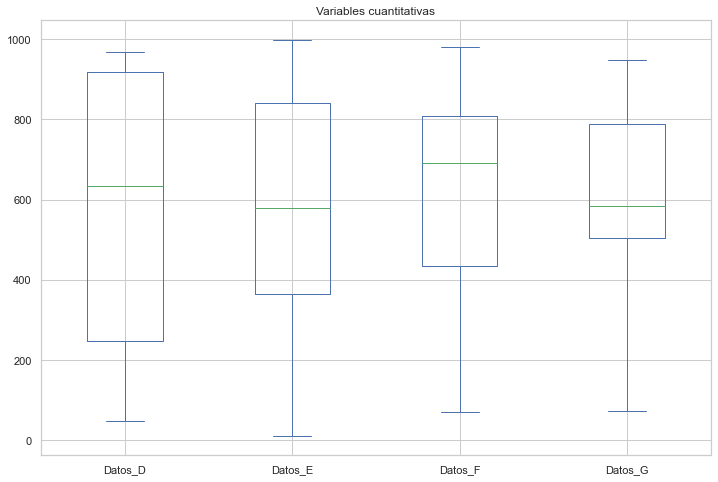

-------------- Graficas de bigotes por dicotomicas-------------------


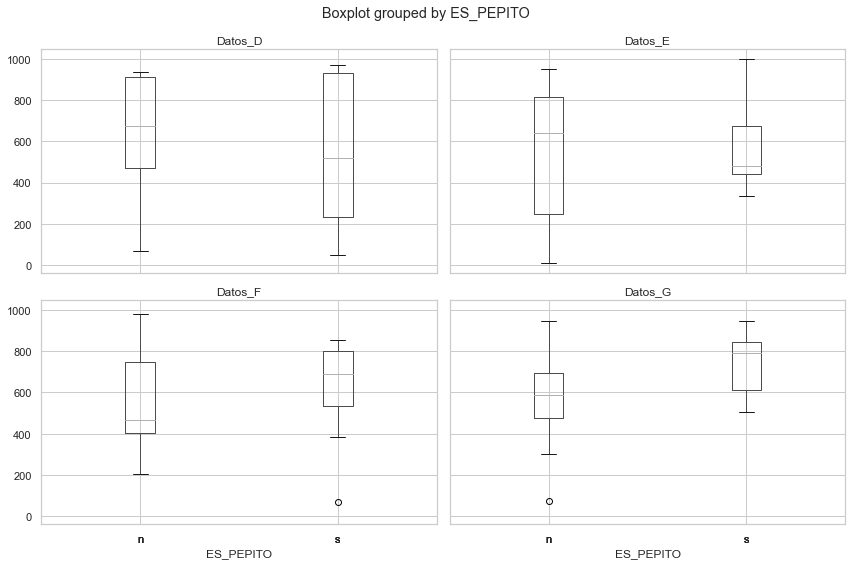

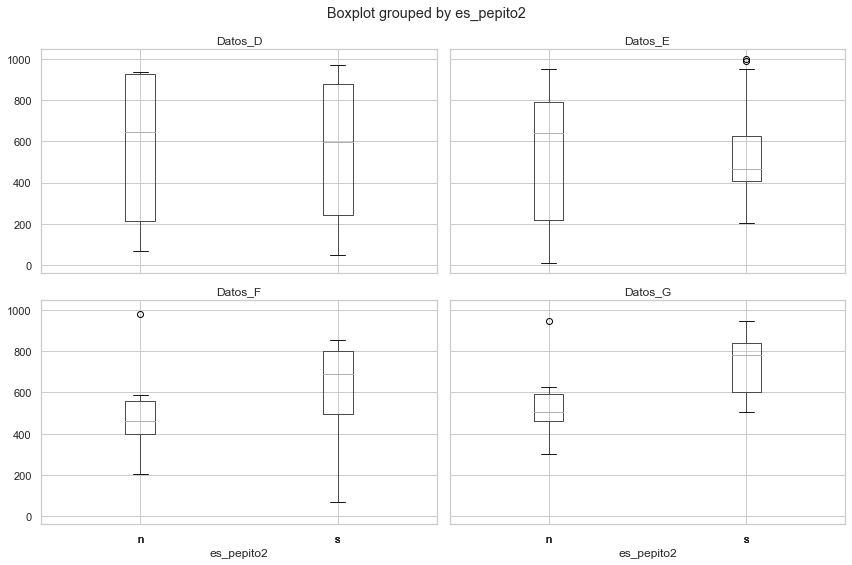

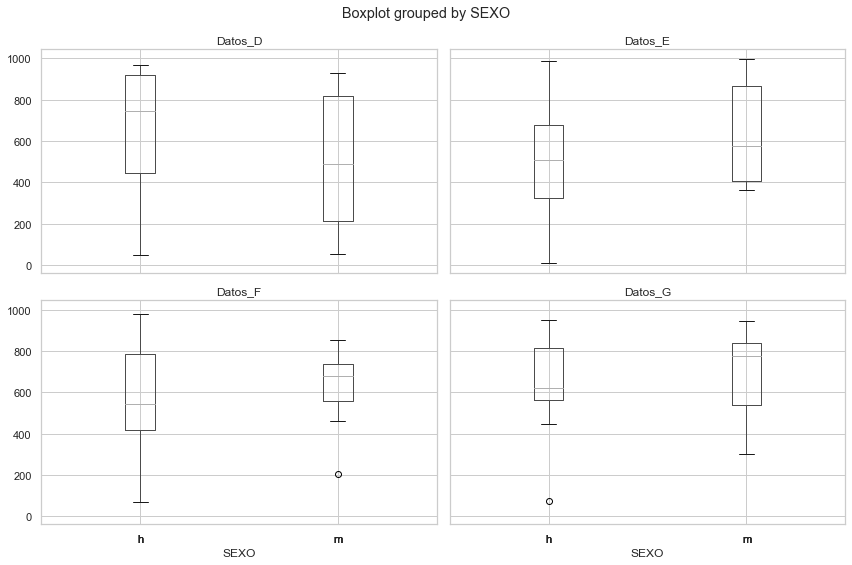

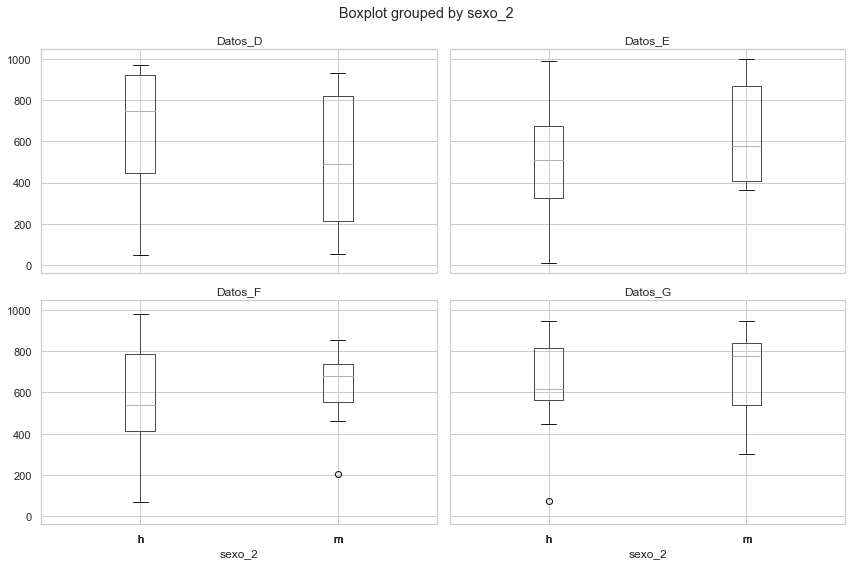



----------------------------------------------------------------------------------------------------

-------------- Graficas de bigotes por categoricas-------------------


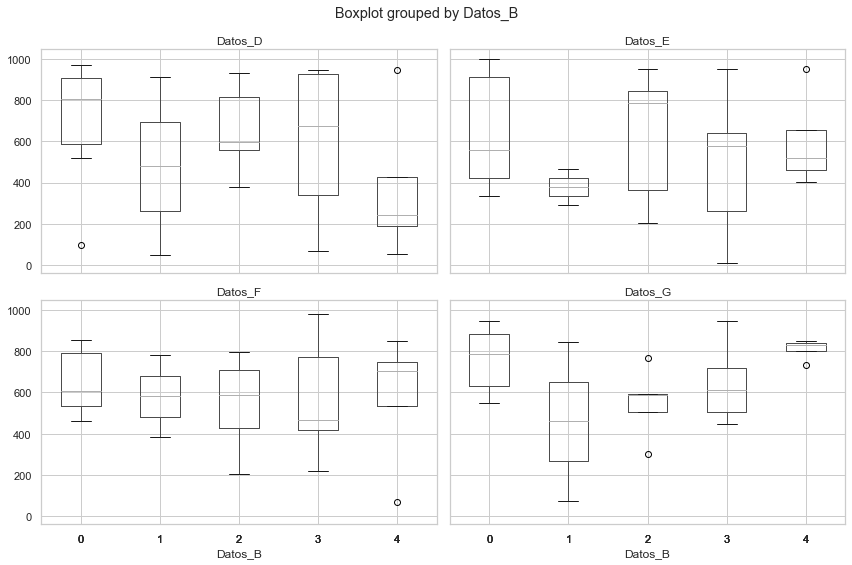

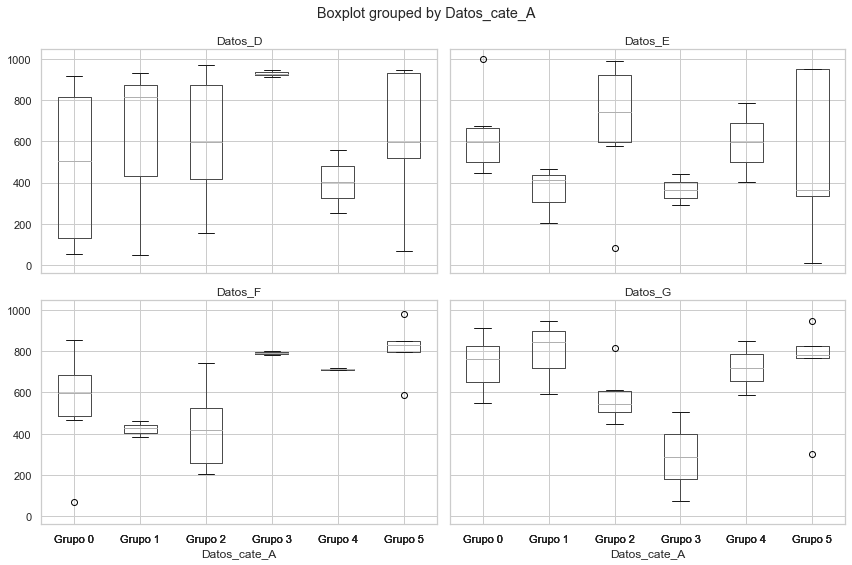

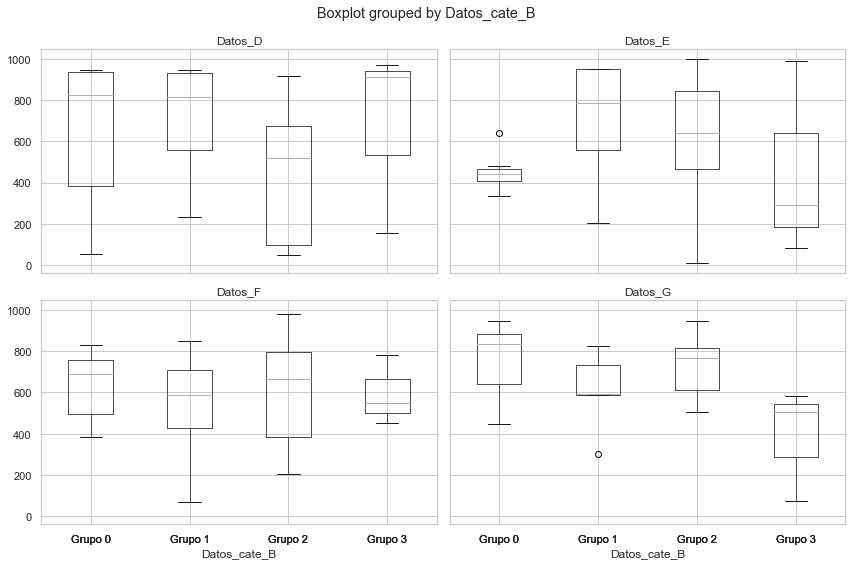

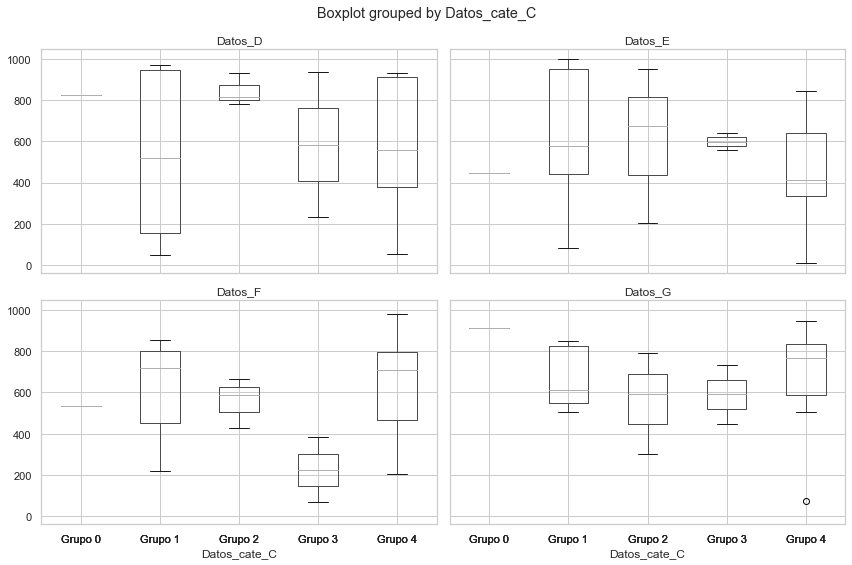



----------------------------------------------------------------------------------------------------


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



In [116]:
ejemplo.plot_bigotes()


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

----------------------------------------------------------------------------------------------------

-------------- GRAFICA DE BARRAS DE TODAS LAS CUANTITATIVAS -------------------



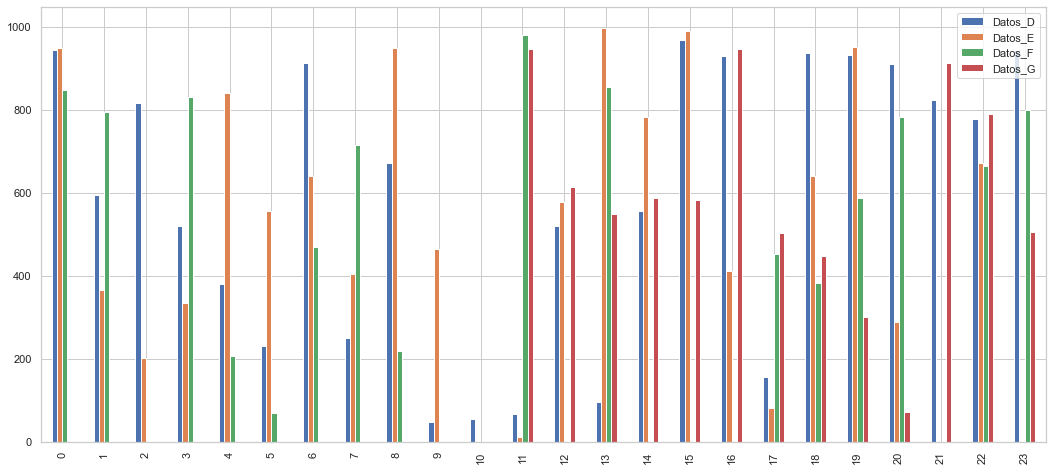

-------------- GRAFICA DE BARRAS CON DISTRIBUCIÓN DE DENSIDAD DE CADA CUANTITATIVA  -------------------


.............. GRAFICA DE BARRAS  DE Datos_D ............



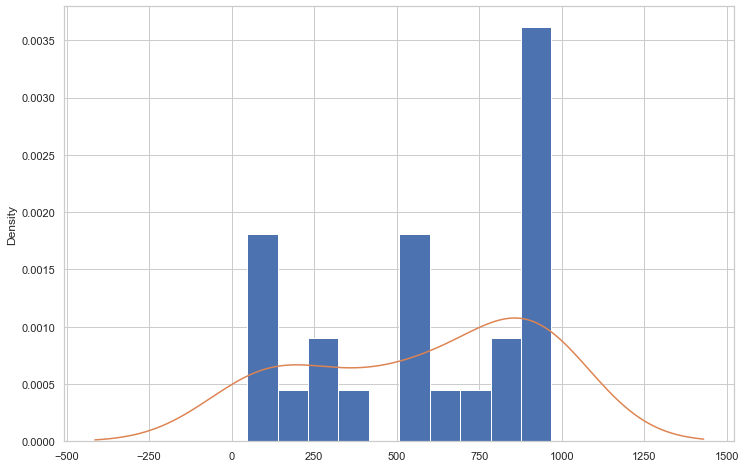


.............. GRAFICA DE BARRAS  DE Datos_E ............



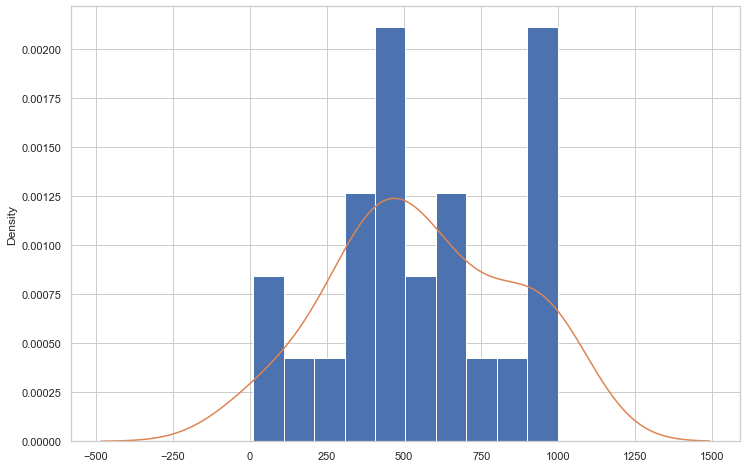


.............. GRAFICA DE BARRAS  DE Datos_F ............



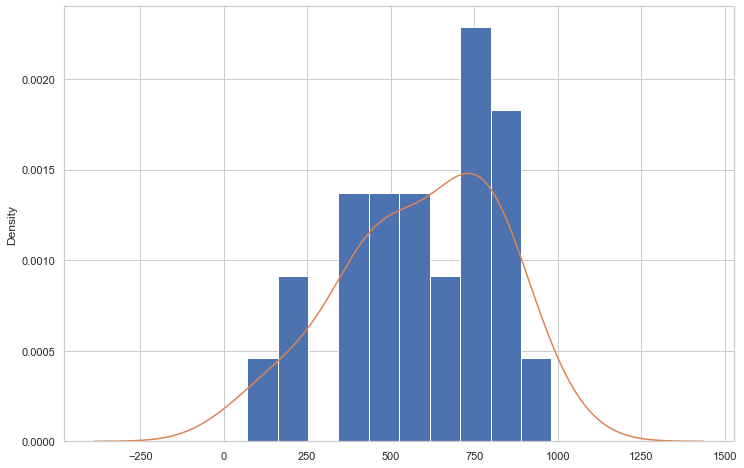


.............. GRAFICA DE BARRAS  DE Datos_G ............



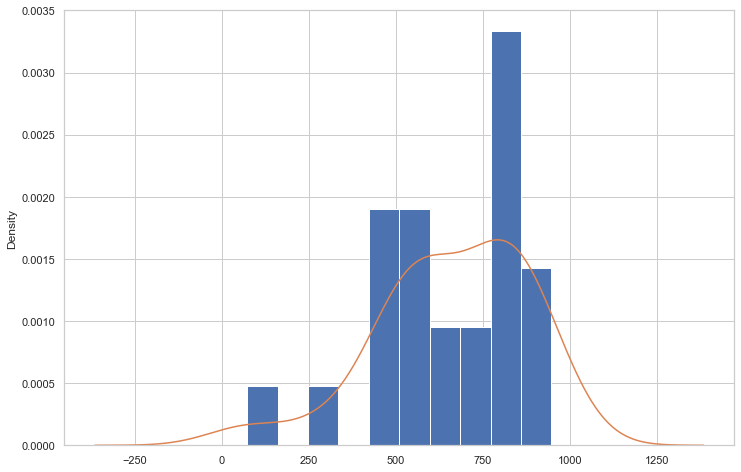

----------------------------------------------------------------------------------------------------


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



In [117]:
ejemplo.plot_barras()


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

----------------------------------------------------------------------------------------------------

-------------- MATRIZ DE CORRELACIONES ENTRE CUANTITATIVAS -------------------



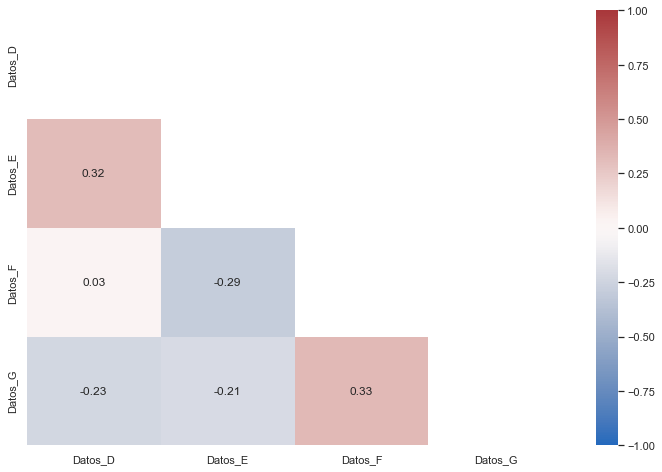

----------------------------------------------------------------------------------------------------


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



In [118]:
ejemplo.plot_corr()

--------------  GRAFICA DE VIOLINES  -------------------



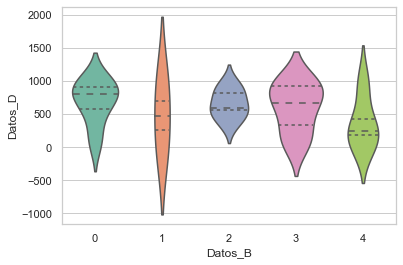

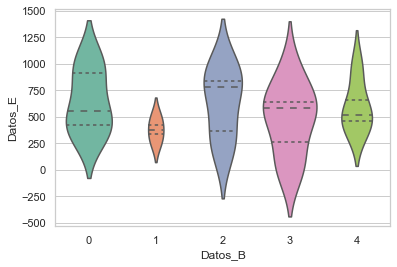

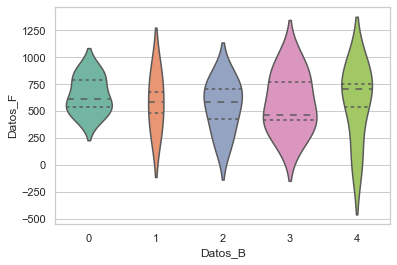

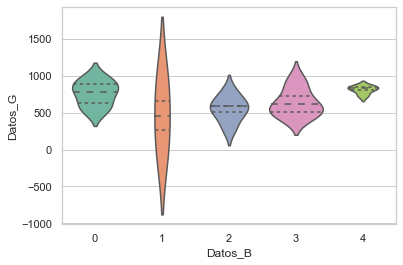

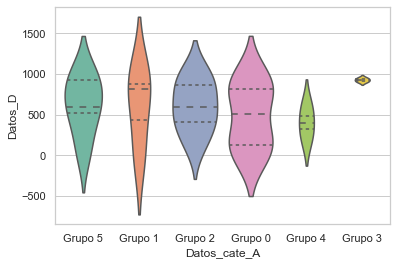

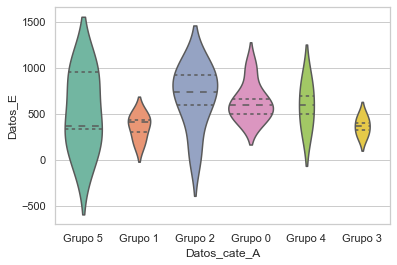

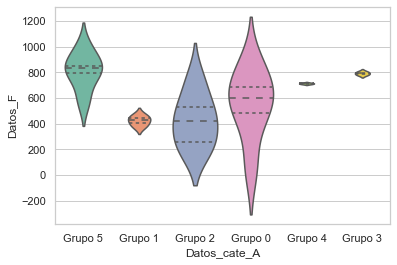

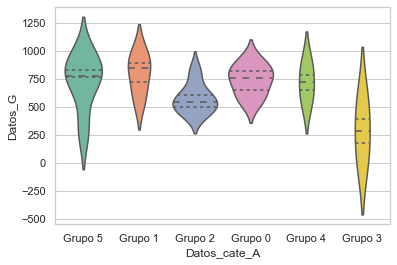

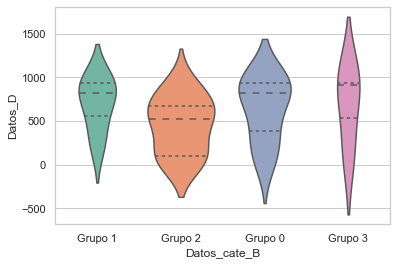

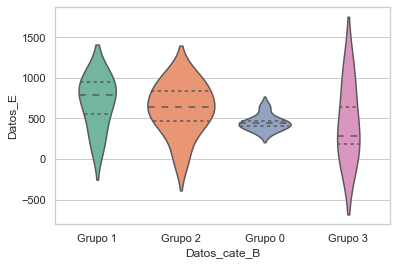

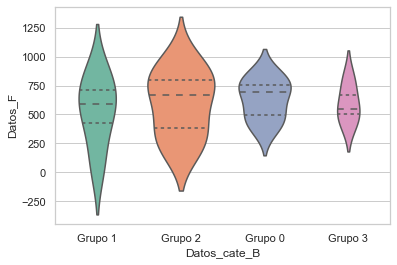

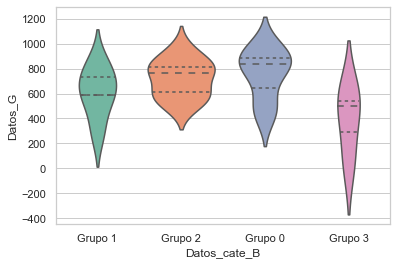

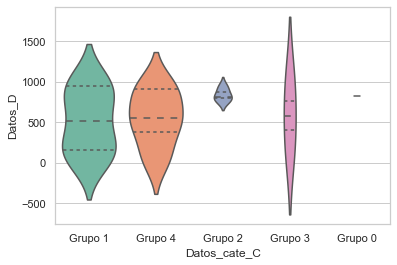

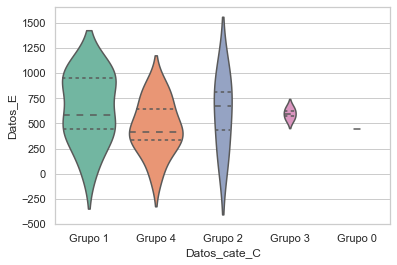

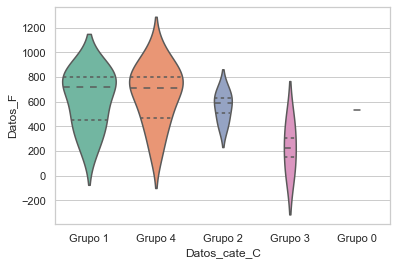

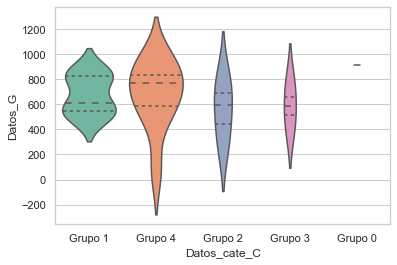



/////////-------------- GRAFICA DE VIOLINES POR DICOTOMICAS -------------------/////////////



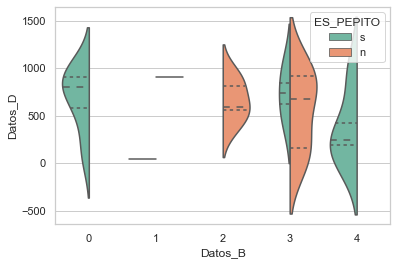

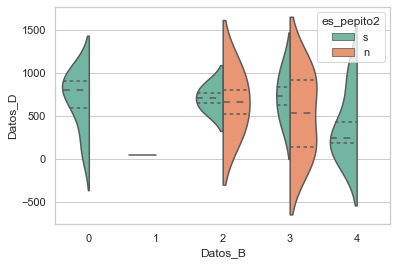

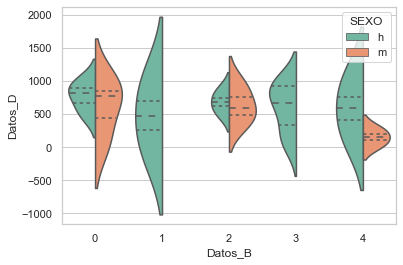

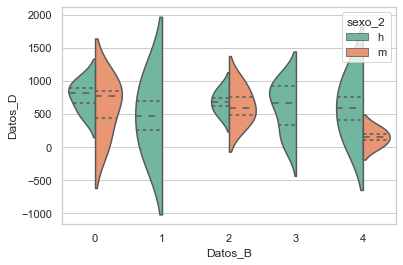

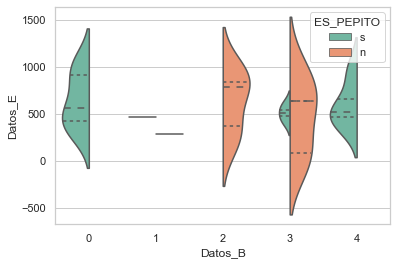

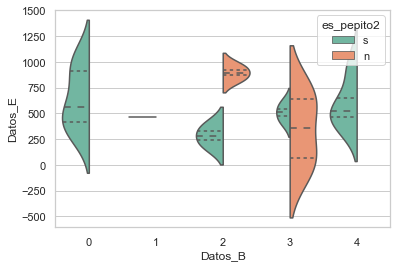

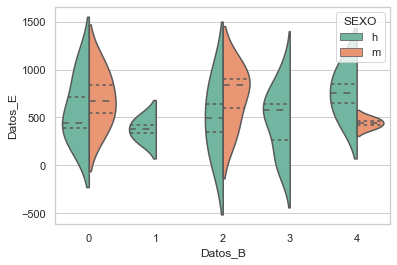

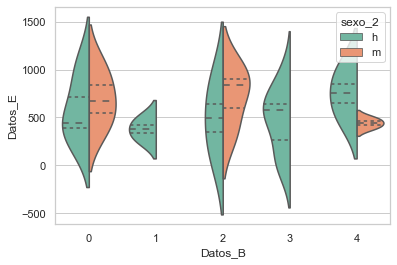

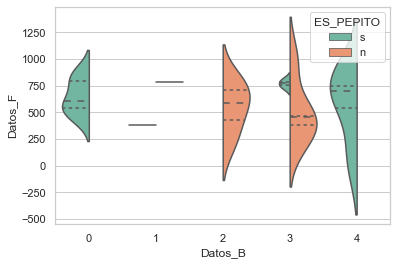

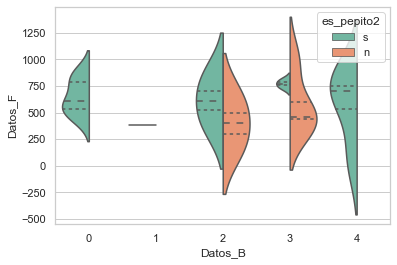

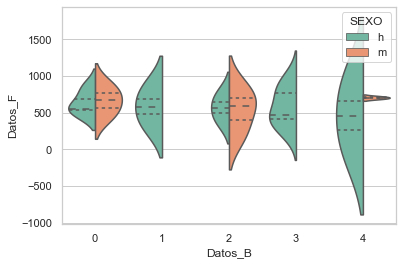

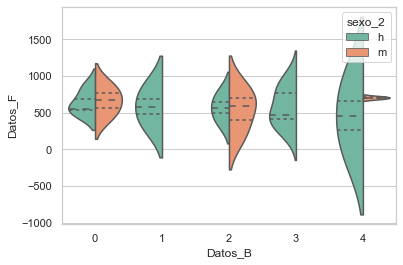

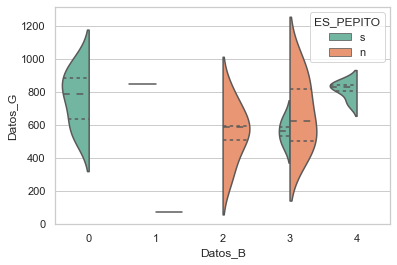

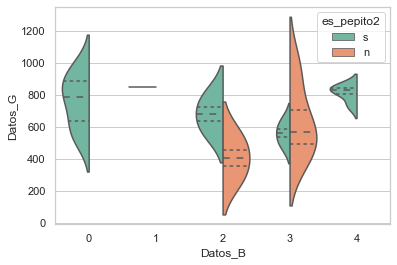

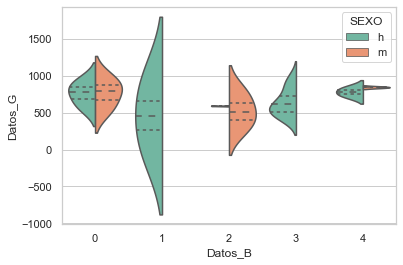

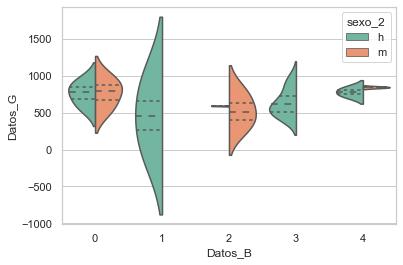

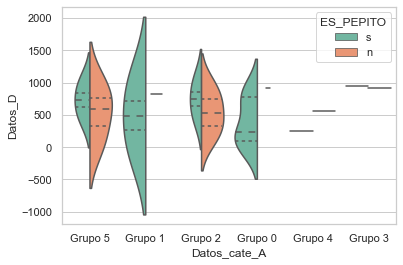

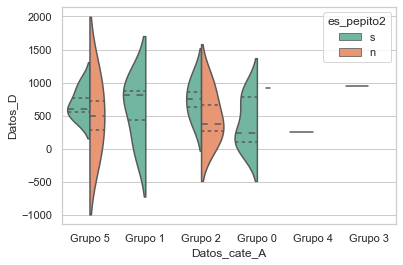

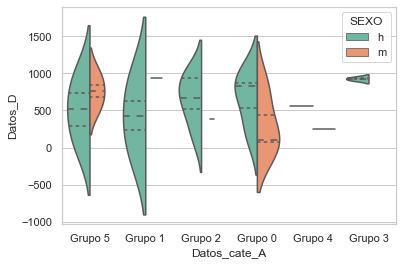

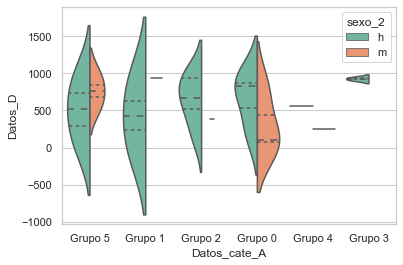

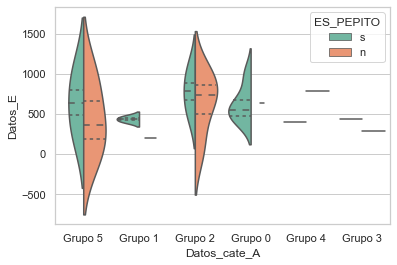

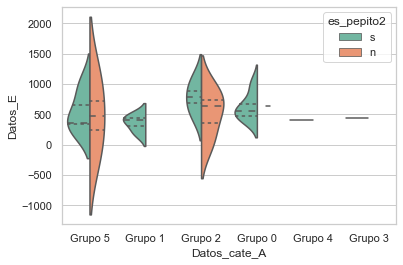

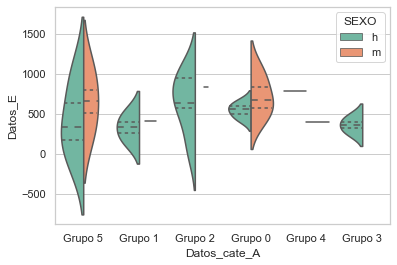

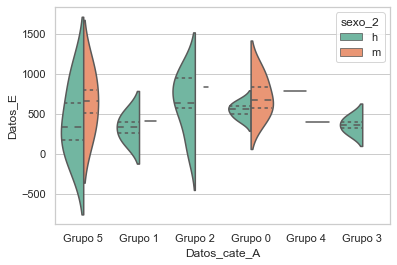

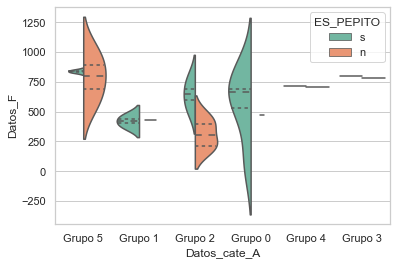

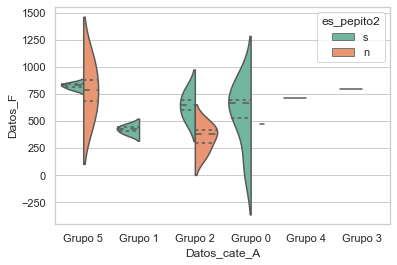

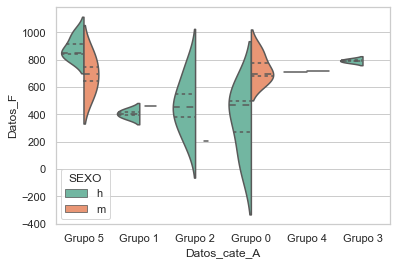

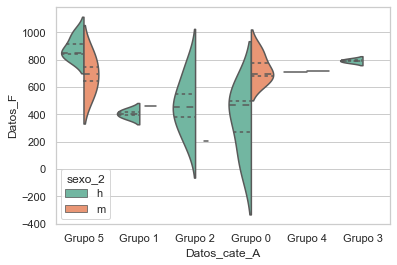

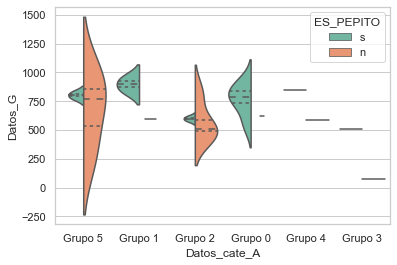

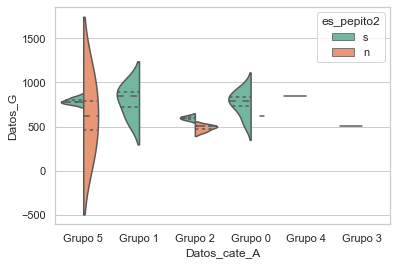

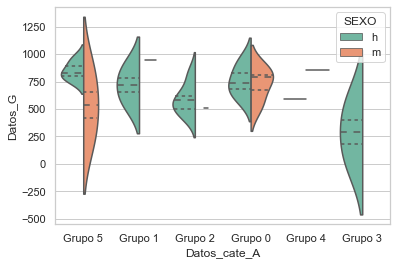

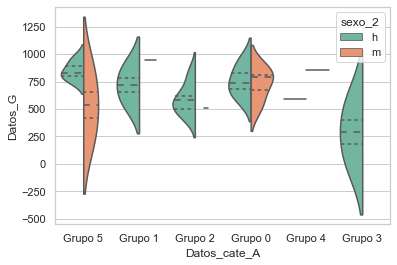

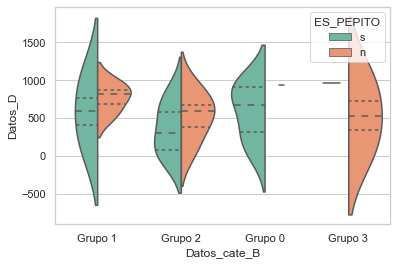

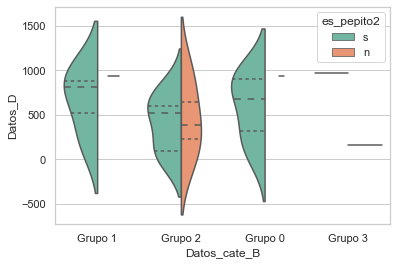

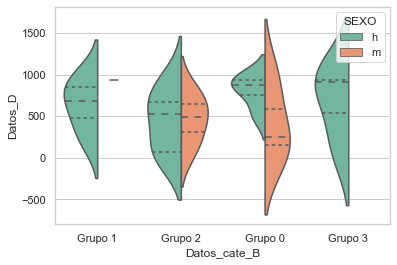

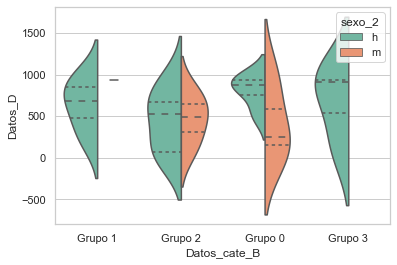

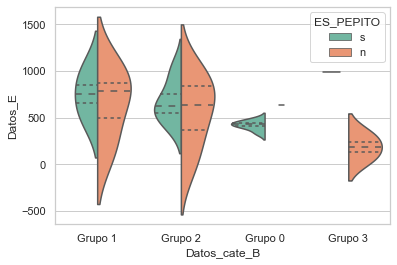

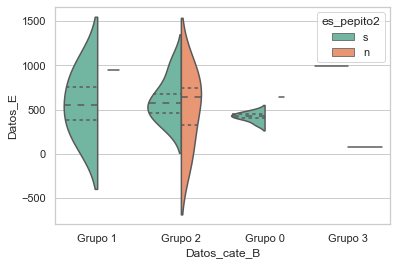

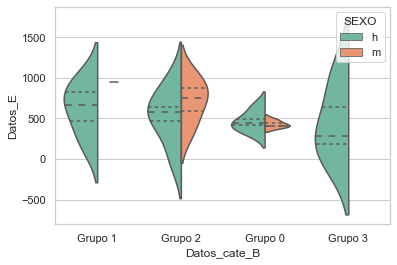

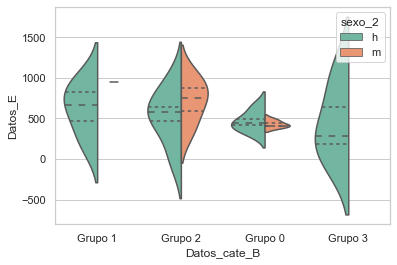

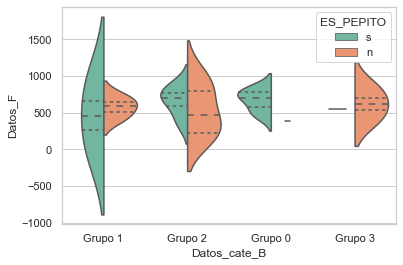

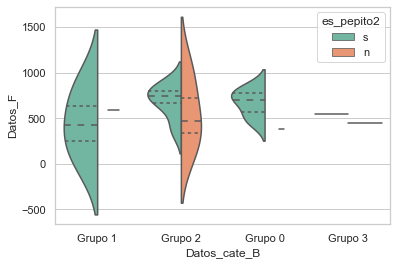

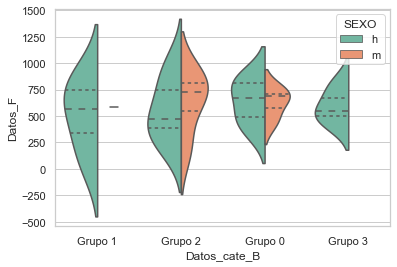

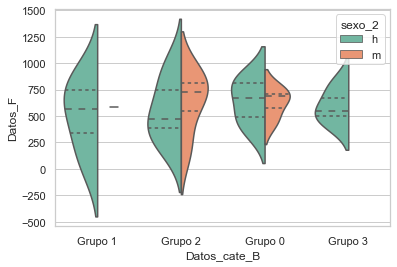

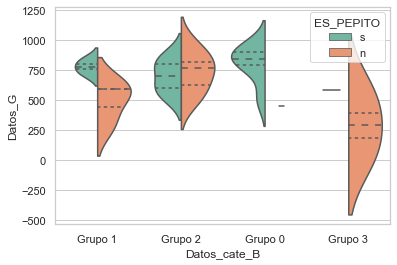

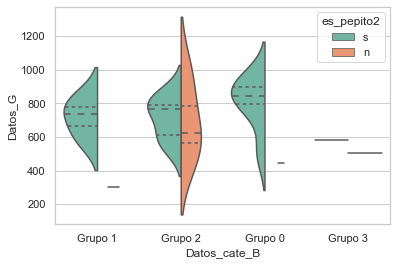

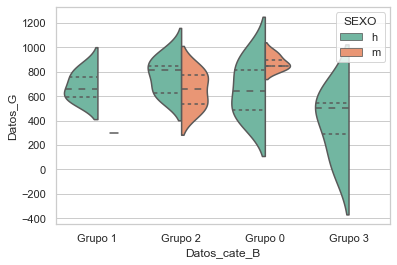

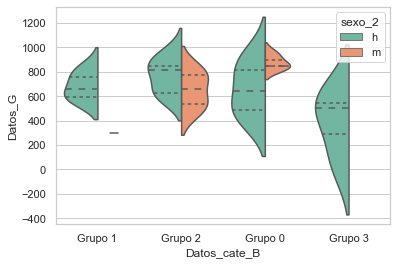

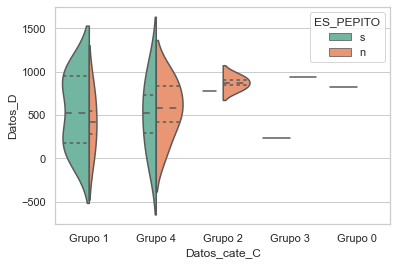

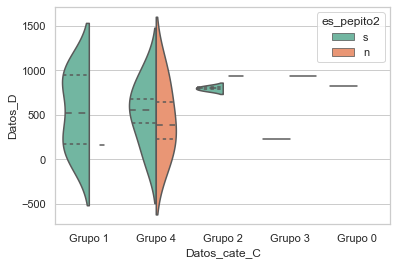

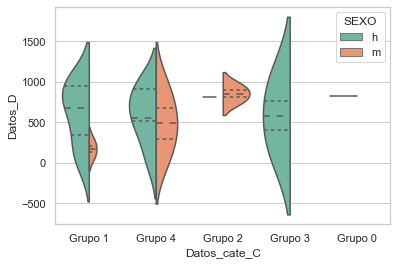

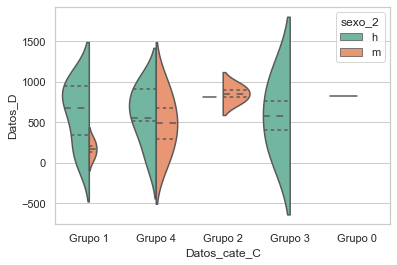

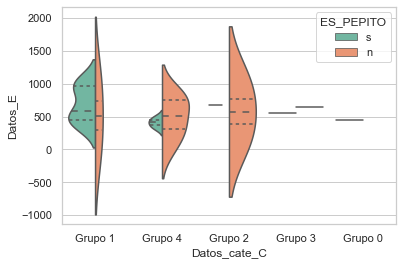

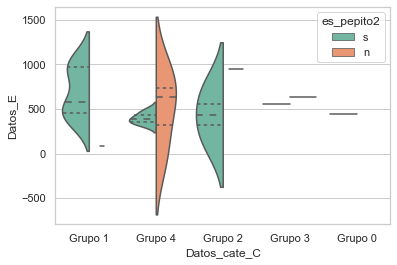

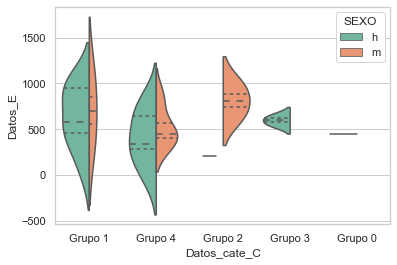

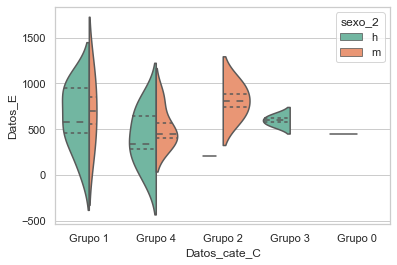

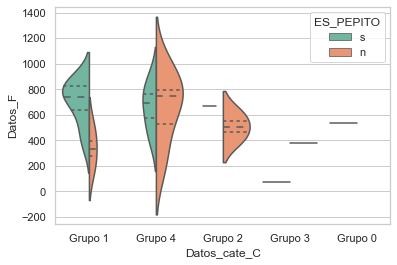

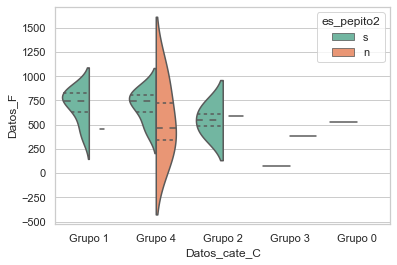

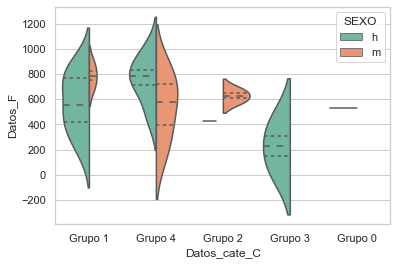

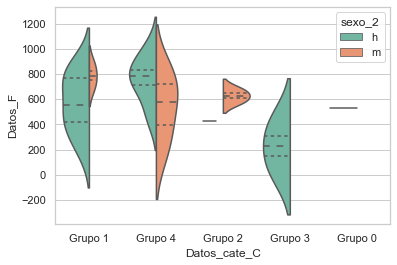

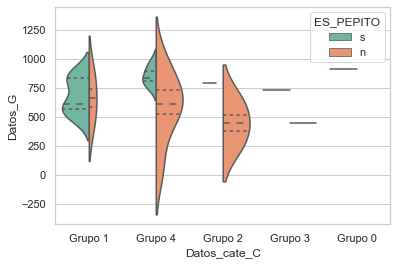

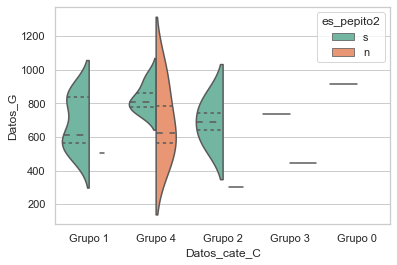

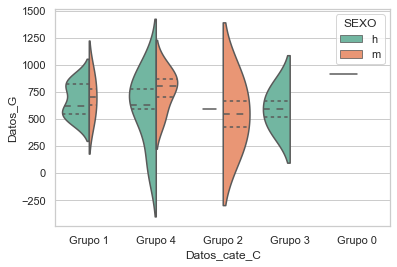

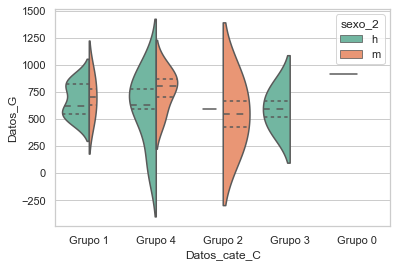

In [119]:
ejemplo.violines()

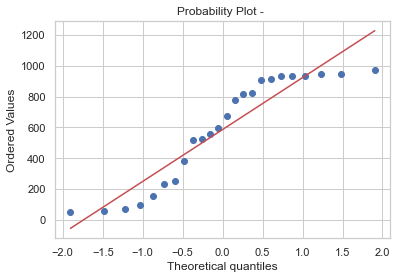

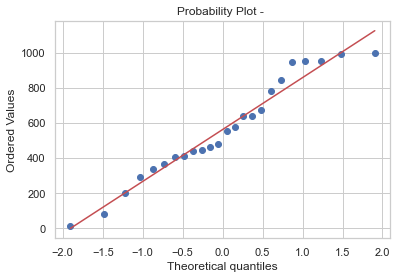

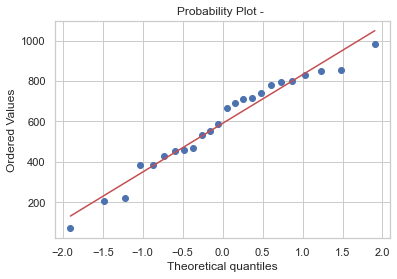

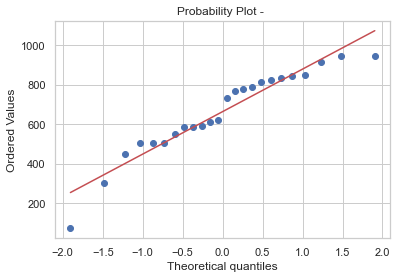

In [120]:
ejemplo.plot_normailidad()

# TEST ESTADISTICOS

## Variables normales y no normales

In [121]:
ejemplo.normalidad()

////////////////////////// TEST DE SHAPIRO CUANTITATIVAS ////////////////////////////
++++++++++++++++++++++++++++  Datos_D  ++++++++++++++++++++++++++

Variable cuantitativa Datos_D y test Shapiro < 0.05
ShapiroResult(statistic=0.863148033618927, pvalue=0.0038730637170374393)


----------------------------------------------------------------------------------------------------

////////////////////////// TEST DE SHAPIRO DICOTOMICAS ////////////////////////////
++++++++++++++++++++++++++++  ES_PEPITO y Datos_D  ++++++++++++++++++++++++++

Agrupado por ES_PEPITO y por Datos_D y test Shapiro < 0.05
ES_PEPITO
n    (0.8738539218902588, 0.08686758577823639)
s    (0.8563838601112366, 0.03452914580702782)
Name: Datos_D, dtype: object


----------------------------------------------------------------------------------------------------

////////////////////////// TEST DE SHAPIRO DICOTOMICAS ////////////////////////////
++++++++++++++++++++++++++++  ES_PEPITO y Datos_E  ++++++++++++++++++++++++

## Chi2

In [122]:
ejemplo.Chi()


-------------- Chi2 entre ES_PEPITO y es_pepito2 ----------------
p: 0.00022024132045215684 


-------------- Chi2 entre ES_PEPITO y SEXO ----------------
p: 0.5623426051791449 


-------------- Chi2 entre ES_PEPITO y sexo_2 ----------------
p: 0.5623426051791449 


-------------- Chi2 entre es_pepito2 y SEXO ----------------
p: 0.7762576671816586 


-------------- Chi2 entre es_pepito2 y sexo_2 ----------------
p: 0.7762576671816586 


-------------- Chi2 entre SEXO y sexo_2 ----------------
p: 9.63357008643095e-07 



## T_student

# Wilconxon

## Anova

In [123]:
ejemplo.anova()


----------- ANOVA Categoria Datos_B y variable continua Datos_D ----------

                sum_sq    df        F    PR(>F)
Datos_B   1.387723e+05   1.0  1.19798  0.285565
Residual  2.548448e+06  22.0      NaN       NaN

----------- ANOVA Categoria Datos_B y variable continua Datos_E ----------

                sum_sq    df         F    PR(>F)
Datos_B   1.628224e+04   1.0  0.190495  0.666758
Residual  1.880413e+06  22.0       NaN       NaN

----------- ANOVA Categoria Datos_B y variable continua Datos_F ----------

                sum_sq    df         F    PR(>F)
Datos_B   1.468231e+04   1.0  0.258393  0.616286
Residual  1.250075e+06  22.0       NaN       NaN

----------- ANOVA Categoria Datos_B y variable continua Datos_G ----------

                sum_sq    df         F    PR(>F)
Datos_B   1.195377e+03   1.0  0.025027  0.875742
Residual  1.050780e+06  22.0       NaN       NaN

----------- ANOVA Categoria Datos_cate_A y variable continua Datos_D ----------

                    sum_s

In [124]:
# # stats f_oneway functions takes the groups as input and returns ANOVA F and p value
# fvalue, pvalue = stats.f_oneway(df['A'], df['B'], df['C'], df['D'])
# print(fvalue, pvalue)
# # 17.492810457516338 2.639241146210922e-05

# # get ANOVA table as R like output
# import statsmodels.api as sm
# from statsmodels.formula.api import ols

# # Ordinary Least Squares (OLS) model
# model = ols('value ~ C(treatments)', data=df_melt).fit()
# anova_table = sm.stats.anova_lm(model, typ=2)
# anova_table
# # output (ANOVA F and p value)
#                 sum_sq    df         F    PR(>F)
# C(treatments)  3010.95   3.0  17.49281  0.000026
# Residual        918.00  16.0       NaN       NaN

# # ANOVA table using bioinfokit v1.0.3 or later (it uses wrapper script for anova_lm)
# from bioinfokit.analys import stat
# res = stat()
# res.anova_stat(df=df_melt, res_var='value', anova_model='value ~ C(treatments)')
# res.anova_summary
# # output (ANOVA F and p value)
#                  df   sum_sq   mean_sq         F    PR(>F)
# C(treatments)   3.0  3010.95  1003.650  17.49281  0.000026
# Residual       16.0   918.00    57.375       NaN       NaN

# # note: if the data is balanced (equal sample size for each group), Type 1, 2, and 3 sums of squares
# # (typ parameter) will produce similar results.

In [125]:
# import statsmodels.api as sm
# from statsmodels.formula.api import ols
#  
# for x in categorical_col:
#     model = ols('cnt' + '~' + x, data = BIKE).fit() #Oridnary least square method
#     result_anova = sm.stats.anova_lm(model) # ANOVA Test
#     print(result_anova)